<a href="https://colab.research.google.com/github/Akifsula/Pusula_Akif_Emre_Sula/blob/main/drug_side_effect_veri_on_isleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;">Drug Side Effect Data Preprocessing 💊</h1>

Bu notebookta veri ön işleme (data preprocessing) yaparak elimizdeki veriyi temizleyip, modellemeye hazır hale getireceğim. Bu aşama; eksik verilerle başa çıkma, kategorik değişkenleri kodlama, sayısal özellikleri normalleştirme veya standartlaştırma ve veri kalitesi sorunlarını çözmeyi içerir.
Amacım veri setini dengeli bir hale getirip makine öğrenmesi modellerinin daha yüksek başarım vermesini sağlamaktır.

In [34]:
# Gerekli kütüphaneleri içe aktarıyorum.
import numpy as np  # Sayısal işlemler
import pandas as pd  # Veri manipülasyonu
import seaborn as sns  # Görselleştirme
import matplotlib.pyplot as plt  # Görselleştirme
from itertools import combinations  # Olası kombinasyon hesabı
import random  # Rastgele değerler
from IPython.display import display  # Dataframe
import difflib  # Karşılaştırma & benzerlik
from collections import Counter  # Sayma işlemleri

from sklearn.preprocessing import LabelEncoder  # Kategorik değişkenleri kodlama
from sklearn.impute import KNNImputer  # Eksik değer atama

# Görsel çıktılarındaki Python uyarı mesajlarını kapatıyorum.
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Veri setimi içeri aktarıyorum.
file_path = 'side_effect_data 1.xlsx'

veri = pd.read_excel(file_path)

In [6]:
# Orijinal veri setinin yapısını korumak için copy() metotu ile veri setinin yedeğini alıyorum.
df = veri.copy()

**Gereksiz Öznitelik**

İlk ele alacağım işlem EDA aşamasında da söylediğim gibi "Uyruk" kategorisi.Bu kategorideki tüm değerler aynı olduğu için, bu öznitelik modelin öğrenmesine katkıda bulunmayacaktır. Bu tür öznitelikler modelleme aşamasında herhangi bir bilgi sunmadığından, veri ön işleme aşamasında bu kategoriyi kaldırmak en uygun yaklaşım olacaktır.

In [7]:
# 'Uyruk' kolonunu kaldır
df = df.drop(columns=['Uyruk'])

**Kategori İsimleri**

Kategori isimlerini veri ön işleme aşamasında tutarlı bir biçimde güncellemenin iyi bir yaklaşım olacağını düşünüyorum. Bu, özellikle daha büyük projelerde ve veri işleme adımlarında isimlendirme tutarsızlıklarından kaynaklanan hataların önüne geçecektir. Belirli bir format (örneğin, alt çizgi kullanmak ve küçük harflerle yazmak) hem kodun okunabilirliğini artırır hem de sonraki adımlarda işlemleri kolaylaştırır.

In [12]:
# Bu kod tüm sütun adlarını küçük harfe çevirip boşlukları alt çizgiyle değiştirir.
df.columns = df.columns.str.lower().str.replace(' ', '_')


Bazı kategori isimlerinin modelleme için çok uzun olduğunu düşündüm. Bu yüzden birkaçında güncellemeler yapmak istiyorum.

In [14]:
# Sadece belirli sütun isimlerini değiştirmek için bir sözlük oluşturalım
updated_column_names = {
    'baba_kronik_hastaliklari': 'baba_kronik_hast',
    'anne_kronik_hastaliklari': 'anne_kronik_hast',
    'kiz_kardes_kronik_hastaliklari': 'kiz_kar_kronik_hast',
    'erkek_kardes_kronik_hastaliklari': 'erkek_kar_kronik_hast',
    'yan_etki_bildirim_tarihi': 'yan_etki_bild_tar'
}

# Sadece belirli sütun isimlerini güncelleyelim
df.rename(columns=updated_column_names, inplace=True)

In [15]:
# Yaptığım kategori değişikliklerini kontrol etmek için
print(df.columns)

Index(['kullanici_id', 'cinsiyet', 'dogum_tarihi', 'il', 'ilac_adi',
       'ilac_baslangic_tarihi', 'ilac_bitis_tarihi', 'yan_etki',
       'yan_etki_bild_tar', 'alerjilerim', 'kronik_hastaliklarim',
       'baba_kronik_hast', 'anne_kronik_hast', 'kiz_kar_kronik_hast',
       'erkek_kar_kronik_hast', 'kan_grubu', 'kilo', 'boy'],
      dtype='object')


**Tarih Değerleri**

Tarih bilgisi içeren kategorilerdeki aşırı ayrıntıların (saat, dakika, saniye gibi) modelin karmaşıklığını artırabileceğini tespit etmiştim. Özellikle saat bilgisi gibi bileşenlerin modelleme aşamasında genellikle anlamlı bir katkı sağlamadığı durumlarda bu ayrıntıları çıkarmak, daha basit ve verimli bir model elde etmenize yardımcı olabilir.

In [20]:
# 'yan_etki_bild_tar' sütunundaki saat, dakika ve saniye bilgilerini çıkararak yalnızca tarih kısmını tutalım
df['yan_etki_bild_tar'] = df['yan_etki_bild_tar'].dt.date

# Eski verilerle karşılaştırma yapmak için:
print(df['yan_etki_bild_tar'].head())
print(veri['Yan_Etki_Bildirim_Tarihi'].tail())

0    2022-02-19
1    2022-02-03
2    2022-02-04
3    2022-02-08
4    2022-02-12
Name: yan_etki_bild_tar, dtype: object
2352   2022-02-12 19:13:43
2353   2022-02-19 17:39:48
2354   2022-02-03 20:48:17
2355   2022-02-04 05:29:20
2356   2022-02-17 07:08:01
Name: Yan_Etki_Bildirim_Tarihi, dtype: datetime64[ns]


**Uzun Ve Tekrarlayan İlaç İsimlerine Çözüm**

Detaylı analizler ve gerçek dünya araştırmalarından çıkardığım bulgularla ilac_adi kategorisindeki verilerin bazılarının aynı ilaca ait farklı formlar, farklı yazılışlar ya da daha uzun adlandırmalardan oluştuğunu gördüm. (Örneğin: "divalproex sodium", "divalproeks sodyum er", "divalproex sodium capsule, sprinkle" öznelerinin hepsi aynı etken maddeye ait ilacın farklı formları.) Tüm  ilaç isimlerini teker teker ayrıştırıp kategorize etmek çok kompleks kütüphaneler ve çeşitli işlemler gerektirdiği için ve aynı zamanda veri kaybı riski de oluşturacağından çözüm olarak ilac_adi sütunundaki tüm ilaç isimlerinin yalnızca ilk iki kelimesini almaya karar verdim. Çünkü fark ettim ki ilaçların hepsi ana ilaç adıyla başlayıp formuna ya da kullanım şekline göre türetiliyor. Yani ilk iki kelimesi o kategori için kesinlikle ayırt edici oluyor. İşte bunu gerçekleştiren basit kod parçacığı:



In [28]:
# İlk iki kelimeyi almak için ilac_adi kategorisini güncelle
df['ilac_adi'] = df['ilac_adi'].apply(lambda x: ' '.join(x.split()[:2]))
df['ilac_adi'].head(10)

,ilac_adi
0,trifluoperazine
1,fluphenazine hcl
2,warfarin sodium
3,valproic acid
4,carbamazepine extended
5,fluoxetine dr
6,carbamazepine extended
7,thiothixene
8,"asenapine tablet,"
9,fluphenazine hcl


# Eksik Değerlerle Başa Çıkma

**Cinsiyet Kategorisi**

Bu kategorideki eksik değerleri doldururken sırasıyla şu işlemleri yapmayı ve şu analizleri referans almayı düşünüyorum:


1.   İlk olarak hem cinsiyeti hem de boy bilgisi olmayan hastaları tespit edip bu hastaların cinsiyet bilgilerini EDA aşamasında oluşturduğum yan etki ve cinsiyet arasındaki ısı haritasından aldığım verilere göre dolduracağım (yan_etkiler kategorisinde Gec Bosalma, Istah Artisi, Uykululuk Hali verilerinden herhangi biri varsa Female değeri atanacak. yan_etkiler kategorisinde Carpinti, Kabizlik, Terleme verilerinden herhangi biri varsa Male değeri atanacak.  Eğer hem cinsiyeti eksik hem boyu eksik hem de yan_etkiler kategorisinde bu saydığım verilerden farklı bir değer varsa o zaman cinsiyet değerine en çok tekrar eden veriye göre Male ya da Female atanacak.)
2.   Eğer hastanın sadece Cinsiyet bilgisi eksikse (Boy bilgisi varsa) 170 boyunun üzerinde olan kayıtların cinsiyet bilgisini Male, 170 boyunun altında olan kayıtların cinsiyet bilgisini Female olarak atayacağım.
3.   Sütundaki tüm kayıtlar dolu hale geldikten sonra dil bütünlüğünü sağlamak ve modelleme yaparken kolaylık oluşması adına Male değerlerine E harfi (Erkek), Female değerlerine K harfi (Kadın) atayacağım.



In [21]:
# Cinsiyet ve Boy bilgisi eksik olan hastaları tespit etme
missing_gender_height = df[df['cinsiyet'].isnull() & df['boy'].isnull()]

# Yan etkiler kategorisine göre cinsiyet atama
def fill_gender_based_on_side_effects(row):
    if any(effect in row['yan_etki'] for effect in ['Gec Bosalma', 'Istah Artisi', 'Uykululuk Hali']):
        return 'Female'  # Kız
    elif any(effect in row['yan_etki'] for effect in ['Carpinti', 'Kabizlik', 'Terleme']):
        return 'Male'  # Erkek
    else:
        return df['cinsiyet'].mode()[0]  # En sık tekrarlayan değeri atama

# Eksik cinsiyet bilgisi olan hastalara cinsiyet atama
df.loc[missing_gender_height.index, 'cinsiyet'] = missing_gender_height.apply(fill_gender_based_on_side_effects, axis=1)


In [22]:
# Sadece cinsiyet bilgisi eksik olan hastaları tespit etme
missing_gender = df[df['cinsiyet'].isnull() & df['boy'].notnull()]

# Boy bilgisine göre cinsiyet atama
df.loc[missing_gender[missing_gender['boy'] > 170].index, 'cinsiyet'] = 'Male'  # Erkek
df.loc[missing_gender[missing_gender['boy'] <= 170].index, 'cinsiyet'] = 'Female'  # Kız


In [23]:
# Tüm kayıtların dolu olduğundan emin olalım
print(df['cinsiyet'].isnull().sum())  # Null değer sayısını kontrol et


0


In [24]:
# Cinsiyet değerlerini güncelle
df['cinsiyet'] = df['cinsiyet'].replace({'Male': 'E', 'Female': 'K'})
df['cinsiyet'].head()

,cinsiyet
0,E
1,E
2,K
3,E
4,K


**Dikkat ❗**

EDA aşamasasında aynı id numarasına sahip bir hastanın birden fazla kaydının olduğu örneklerin veri setinde bulunduğunu Analiz etmiştim. Dolayısıyla aynı hastaya başka bir tarihte farklı bir yan etki bulgusu yapılabileceği ihtimalini ve bu ihtimal sonucu cinsiyetinin farklı girilebilme durumunu göz önüne almamız gerekiyor. Bunun gibi istisnaların modellemedeki başarı oranını düşürmemesi ve tutarsızlığa yol açmaması için gerekli kontrolleri yapan kodları yazarak Cinsiyet kategorisiyle alakalı işlemlerimizi tamamen bitirmiş olalım.

In [25]:
# Kontrol edilecek sütunlar
kontrol_sutunlari = ['cinsiyet']

for sutun in kontrol_sutunlari:
    # Kullanici_id'si aynı olan kayıtları gruplandır
    kontrol = df.groupby('kullanici_id')[sutun].nunique()

    # Farklı değer sayısı 1 olanları al
    farkli_degerler = kontrol[kontrol > 1]

    # Sonuçları göster
    if not farkli_degerler.empty:
        print(f"Aynı Kullanici_id'ye sahip, farklı {sutun} bilgileri bulunan kayıtlar var:")
        print(farkli_degerler)
        print(f"Farklı sonuç sayısı: {len(farkli_degerler)}")  # Farklı sonuç sayısını göster
    else:
        print(f"Tüm Kullanici_id'leri için {sutun} bilgileri aynı.")

# Farklı cinsiyet bilgileri bulunan kullanıcı ID'leri
for kullanici_id in farkli_degerler.index:
    # Aynı kullanıcı ID'sine sahip kayıtları al
    cinsiyet_bilgileri = df[df['kullanici_id'] == kullanici_id][['kullanici_id', 'cinsiyet']]
    print(f"{kullanici_id} için cinsiyet bilgileri:")
    print(cinsiyet_bilgileri)
    print()  # Yeni bir satır ekle


Aynı Kullanici_id'ye sahip, farklı cinsiyet bilgileri bulunan kayıtlar var:
kullanici_id
37     2
112    2
137    2
Name: cinsiyet, dtype: int64
Farklı sonuç sayısı: 3
37 için cinsiyet bilgileri:
      kullanici_id cinsiyet
160             37        K
281             37        K
789             37        K
918             37        E
1209            37        K
1231            37        K
1616            37        K
1746            37        K
1798            37        K
1818            37        K
1891            37        K
1932            37        K
2273            37        K
2340            37        K

112 için cinsiyet bilgileri:
      kullanici_id cinsiyet
112            112        K
477            112        E
573            112        K
612            112        K
992            112        K
1194           112        E
1732           112        K
2199           112        K
2348           112        K

137 için cinsiyet bilgileri:
      kullanici_id cinsiyet
223            1

Gördüğümüz gibi gerçekten de istisnai durumlar gerçekleşmiş. Bu durumda id si aynı olan hastaların kayıtlarında kendi içerisinde en sık görülen cinsiyet değerini atayarak tutarsızlıkların önüne geçip tek bir cinsiyete indirgeyebilirim.

In [26]:
# Aynı Kullanici_id'ye sahip farklı cinsiyet bilgilerini düzelt
for kullanici_id in df['kullanici_id'].unique():
    # Kullanıcıya ait kayıtları al
    user_records = df[df['kullanici_id'] == kullanici_id]

    if user_records['cinsiyet'].nunique() > 1:
        # En sık görülen cinsiyet değerini bul
        most_common_gender = user_records['cinsiyet'].mode()[0]

        # Tüm kayıtları bu değerle güncelle
        df.loc[df['kullanici_id'] == kullanici_id, 'cinsiyet'] = most_common_gender

Kontrol kodumu tekrar çalıştırarak sorunu düzeltip düzeltemediğimi görmek istiyorum.

In [27]:
# Kontrol edilecek sütunlar
kontrol_sutunlari = ['cinsiyet']

for sutun in kontrol_sutunlari:
    # Kullanici_id'si aynı olan kayıtları gruplandır
    kontrol = df.groupby('kullanici_id')[sutun].nunique()

    # Farklı değer sayısı 1 olanları al
    farkli_degerler = kontrol[kontrol > 1]

    # Sonuçları göster
    if not farkli_degerler.empty:
        print(f"Aynı Kullanici_id'ye sahip, farklı {sutun} bilgileri bulunan kayıtlar var:")
        print(farkli_degerler)
        print(f"Farklı sonuç sayısı: {len(farkli_degerler)}")  # Farklı sonuç sayısını göster
    else:
        print(f"Tüm Kullanici_id'leri için {sutun} bilgileri aynı.")

# Farklı cinsiyet bilgileri bulunan kullanıcı ID'leri
for kullanici_id in farkli_degerler.index:
    # Aynı kullanıcı ID'sine sahip kayıtları al
    cinsiyet_bilgileri = df[df['kullanici_id'] == kullanici_id][['kullanici_id', 'cinsiyet']]
    print(f"{kullanici_id} için cinsiyet bilgileri:")
    print(cinsiyet_bilgileri)
    print()  # Yeni bir satır ekle

Tüm Kullanici_id'leri için cinsiyet bilgileri aynı.


Sorunun düzeldiğini gördüm. Bir sonraki eksik verileri doldurma aşamalarında ileride veri kaybı yaşamamak için tekrarlayan satırlar için doldurmadan önce önlem alacağım ve istisnai durumları önceden hesaba katacağım.

**İl Kategorisi**

il kategorisindeki eksik değerlerin tümünü en çok tekrar eden "Adana" değeriyle doldurmaya karar verdim. Burda cinsiyet örneği için ekstra bir kontrol durumuna gerek yok çünkü il değeri null olan tüm id numaraları için aynı değer atanacak.

In [38]:
# Tüm il değerleri için en sık geçen değeri bul
en_sik_il = df['il'].mode()[0]

# Eksik il değerlerini bu değerle doldur
df['il'] = df['il'].fillna(en_sik_il)

# Son durumu kontrol et
print(df['il'].isnull().sum(), "adet eksik il değeri kaldı.")


0 adet eksik il değeri kaldı.


**İlaç Adı ve Alerji ilişkisi**

Bu kısımda ilaçlarda hiç null değer olmadığı için, gerçek hayatta hastalara verilen ilaçlarda da alerjiler göz önüne alındığı için kişiye verilen ilaca göre alerjisi olmayan öge analiz edilip ona göre bir tahminde bulunulabilir.   Yani örnekle açıklamak gerekirse burada tam olarak şu sistemi düşündüm:  mesela alerjilerim kategorisindeki bir satırda ceviz yazıyor. o değerle aynı satırda bulunan ilac_adi kategorisinde trifluoperazine isimli ilaç varsa eğer, cevize alerjisi olan bir insana trifluoperazine isimli ilaç yazılabiliyor demektir. Yani Bir sonraki alerjilerim kategorisinde null değer varsa  ve null değerin bulunduğu satırdaki ilac_adi kategorisinde bulunan değer trifluoperazine ise o null değere ceviz değerini atayabiliriz demek oluyor. Yine de boş değerler kalırsa eğer, o değerlere en çok tekrarlanan alerjilerim değerini atayabiliriz.

Bu işlem için ilk önce, daha sonra da kullanım kolaylığı sağlaması amacıyla "ilac_adi" adlı kategorideki ilaç adlarını **LabelEncoding** yöntemi ile sayısal değerlere dönüştüreceğiz.

In [30]:
# LabelEncoder ile ilac_adi kategorisini dönüştürme
le = LabelEncoder()
df['ilac_adi_encoded'] = le.fit_transform(df['ilac_adi'])

In [32]:
# Alerjilerim kategorisindeki null değerleri doldur
for index, row in df[df['alerjilerim'].isnull()].iterrows():
    ilac_encoded = row['ilac_adi_encoded']

    # İlgili ilacın Alerjilerim değerini bul
    matching_allergy = df[(df['ilac_adi_encoded'] == ilac_encoded) & (df['alerjilerim'].notnull())]['alerjilerim']

    if not matching_allergy.empty:
        # Eğer eşleşen alerji varsa, ilk bulduğumuz alerjiyi ata
        df.at[index, 'alerjilerim'] = matching_allergy.iloc[0]

# Hala eksik kalan değerleri en sık geçen değerle doldur
most_frequent_allergy = df['alerjilerim'].mode()[0]
df['alerjilerim'].fillna(most_frequent_allergy, inplace=True)

# Son durumu kontrol et
print(df['alerjilerim'].isnull().sum(), "adet eksik alerji değeri kaldı.")
df['alerjilerim'].head(10)

0 adet eksik alerji değeri kaldı.


,alerjilerim
0,Ceviz
1,Toz
2,Muz
3,Pancar
4,Bugday
5,Domates
6,Bugday
7,Ispanak
8,Laktoz
9,Elma


**Kan Grubu Kategorisi**

Bu kısımdaki yaptığım işlemleri 2 aşamada inceleyebiliriz:


1.   Null değerleri en çok tekrar eden kan grubu değeriyle doldurdum. (AB RH-)
2.   **Frequency Encoding**  yöntemiyle, her kategorik değerin veri setinde hangi sıklıkta tekrarlandığını (frekansını) hesapladım. Bu sayede, kategorik veriyi doğrudan bir sayıya dönüştürmek yerine, kategoriye dair bilgiyi frekans temelli sayısal bir değere çeviriyorum.
Nasıl Çalışır:
Frekansları hesaplama:

df['kan_grubu'].value_counts(normalize=True) kısmı, her kategorik değerin ne sıklıkta tekrarlandığını hesaplar ve bu değeri normalize ederek yüzde olarak döner. Yani, örneğin, "A RH+" değeri veri setinde 100 kez varsa ve toplam veri sayısı 1000 ise, value_counts(normalize=True) bu kategori için 0.10 (yani %10) değerini döndürür.
Frekansları kategoriye atama:

df['kan_grubu'].map(kan_grubu_frekansi) kısmı, her kan grubu kategorisini bu frekans değerleriyle eşleştirir. Örneğin, "A RH+" kategorisine sahip satırlara karşılık gelen sütun değeri %10 (0.10) olur. Bu işlem tüm kategoriler için yapılır ve sayısal değerler kategorik sütuna atanır.



In [33]:
# 1. Adım: Eksik 'kan_grubu' değerlerini en sık tekrar eden veriyle dolduralım

# En sık geçen kan_grubu değerini bulalım
most_frequent_kan_grubu = df['kan_grubu'].mode()[0]
print(most_frequent_kan_grubu)


# Eksik değerleri en sık geçen kan grubu ile dolduralım
df['kan_grubu'].fillna(most_frequent_kan_grubu, inplace=True)

# 2. Adım: Kan grubu kategorisini frequency encoding ile kodlayalım

# Her kan grubu değerinin frekansını hesaplayalım
kan_grubu_frekansi = df['kan_grubu'].value_counts(normalize=True)

# Kan grubu sütununu bu frekanslarla değiştirelim
df['kan_grubu_encoded'] = df['kan_grubu'].map(kan_grubu_frekansi)

# Son durumu kontrol edelim
# Kan grubu ve encoded değerleriyle birlikte unique değerleri görmek için
kan_grubu_encoded_df = df[['kan_grubu', 'kan_grubu_encoded']].drop_duplicates().sort_values(by='kan_grubu_encoded', ascending=False)

# Sonuçları yazdır
print(kan_grubu_encoded_df)

AB RH-
   kan_grubu  kan_grubu_encoded
1     AB RH-           0.325838
19     0 RH+           0.116674
7      B RH+           0.108613
11    AB RH+           0.106067
0      B RH-           0.098854
8      0 RH-           0.098430
35     A RH+           0.084005
42     A RH-           0.061519


**Kütüphane Gerektirmiyor mu?**
Bu yöntem doğrudan pandas kütüphanesi ile yapılabilir ve herhangi bir ek kütüphane gerektirmez. value_counts() ve map() fonksiyonları pandas'ın temel fonksiyonlarındandır, bu yüzden ekstra bir kütüphaneye ihtiyaç duymazsınız.

Frequency encoding gibi yöntemler genellikle sayısal bir dönüşüm gerektirdiği için pandas fonksiyonları yeterli olur.

**Boy ve Kilo Kategorileri**

Bu sayısal kategorilerdeki eksik verileri **KNNımputer** yöntemiyle ortalama değer alarak dolduracağım. Fakat işleme başlamadan önce bazı kontrolleri gerçekleştirmekte fayda var. Boy ve Kilo özellikle ilaçların yan etkileri de göz önüne alındığında zaman içerisinde değişkenlik gösterebilen değerler. Bizim veri setimizde de daha önce belirttiğimiz gibi aynı id numarasına sahip hastaların farklı tarihlerdeki verileri olduğu için null değerleri eşledikten sonra değişikliklerden kaynaklı tutarsızlıklarla karşılaşma ihtimalimizi sıfıra indirmeliyiz.

In [35]:
# Kilo kategorisinde null değer bulunan satırları al
null_kilo = df[df['kilo'].isnull()]

# Kullanici_id'si aynı olan ve kilo kategorisinde null olmayan satırları bul
matching_ids = df[df['kullanici_id'].isin(null_kilo['kullanici_id']) & df['kilo'].notnull()]

# Sonucu göster
if not matching_ids.empty:
    print("Kilo kategorisinde null değeri bulunan ve aynı kullanici_id'ye sahip null olmayan satırlar:")
    print(matching_ids[['kullanici_id', 'kilo']])
else:
    print("Kilo kategorisinde null değeri bulunan ve aynı kullanici_id'ye sahip null olmayan satır yok.")


Kilo kategorisinde null değeri bulunan ve aynı kullanici_id'ye sahip null olmayan satır yok.


In [36]:
# Boy kategorisinde null değer bulunan satırları al
null_boy = df[df['boy'].isnull()]

# Kullanici_id'si aynı olan ve boy kategorisinde null olmayan satırları bul
matching_ids_boy = df[df['kullanici_id'].isin(null_boy['kullanici_id']) & df['boy'].notnull()]

# Sonucu göster
if not matching_ids_boy.empty:
    print("Boy kategorisinde null değeri bulunan ve aynı kullanici_id'ye sahip null olmayan satırlar:")
    print(matching_ids_boy[['kullanici_id', 'boy']])
else:
    print("Boy kategorisinde null değeri bulunan ve aynı kullanici_id'ye sahip null olmayan satır yok.")


Boy kategorisinde null değeri bulunan ve aynı kullanici_id'ye sahip null olmayan satır yok.


Kontrollerimi sağladıktan sonra boş olan değerlerimi ortalama ile doldurmaya başlıyorum:

In [39]:
print(df.isnull().sum())
print(df['kilo'].head(10))
print(df['boy'].head(10))

kullanici_id               0
cinsiyet                   0
dogum_tarihi               0
il                         0
ilac_adi                   0
ilac_baslangic_tarihi      0
ilac_bitis_tarihi          0
yan_etki                   0
yan_etki_bild_tar          0
alerjilerim                0
kronik_hastaliklarim     392
baba_kronik_hast         156
anne_kronik_hast         217
kiz_kar_kronik_hast       97
erkek_kar_kronik_hast    121
kan_grubu                  0
kilo                     293
boy                      114
ilac_adi_encoded           0
kan_grubu_encoded          0
dtype: int64
0    103.0
1     81.0
2     93.0
3      NaN
4     99.0
5     66.0
6      NaN
7     96.0
8     91.0
9    107.0
Name: kilo, dtype: float64
0    191.0
1    181.0
2    158.0
3    165.0
4    172.0
5    150.0
6    147.0
7    162.0
8      NaN
9    156.0
Name: boy, dtype: float64


In [42]:

# Sadece kilo sütunu ile yeni bir DataFrame oluştur
kilo_df = df[['kilo']]

# KNNImputer nesnesini oluştur (k = 2, varsayılan olarak ortalamayı kullanır)
imputer = KNNImputer(n_neighbors=2)

# KNNImputer ile eksik kilo değerlerini doldur
df['kilo'] = np.round(imputer.fit_transform(kilo_df)).astype(int)  # Bulunan ortalama değeri tam sayıya yuvarlıyorum

# Sonucu kontrol et
print(df['kilo'].isnull().sum(), "adet eksik kilo değeri kaldı.")

0 adet eksik kilo değeri kaldı.


In [41]:

# Sadece boy sütunu ile yeni bir DataFrame oluştur
boy_df = df[['boy']]

# KNNImputer nesnesini oluştur (k = 2, varsayılan olarak ortalamayı kullanır)
imputer = KNNImputer(n_neighbors=2)

# KNNImputer ile eksik boy değerlerini doldur
df['boy'] = np.round(imputer.fit_transform(boy_df)).astype(int)  # Bulunan ortalama değeri tam sayıya yuvarlıyorum

# Sonucu kontrol et
print(df['boy'].isnull().sum(), "adet eksik boy değeri kaldı.")

0 adet eksik boy değeri kaldı.


In [43]:
print(df.isnull().sum())
print(df['kilo'].head(10))
print(df['boy'].head(10))

kullanici_id               0
cinsiyet                   0
dogum_tarihi               0
il                         0
ilac_adi                   0
ilac_baslangic_tarihi      0
ilac_bitis_tarihi          0
yan_etki                   0
yan_etki_bild_tar          0
alerjilerim                0
kronik_hastaliklarim     392
baba_kronik_hast         156
anne_kronik_hast         217
kiz_kar_kronik_hast       97
erkek_kar_kronik_hast    121
kan_grubu                  0
kilo                       0
boy                        0
ilac_adi_encoded           0
kan_grubu_encoded          0
dtype: int64
0    103
1     81
2     93
3     81
4     99
5     66
6     81
7     96
8     91
9    107
Name: kilo, dtype: int64
0    191
1    181
2    158
3    165
4    172
5    150
6    147
7    162
8    175
9    156
Name: boy, dtype: int64


**Kronik Hastalıklar Kategorileri**

Bu kategorilerde ön işlemeyi önem sırasına göre 2 ye ayırarak yapacağım. Benim için asıl önemli olan 1. kısım hastanın kendi kronik hastalıkları. Bu yüzden "kronik_hastalıklarim" kategorisindeki null değerleri doldururken daha ayrıntılı incelemeler yapacağım. 2. kısım olarak kişinin ailesindeki kronik hastalıkları ise en çok tekrarlayanlara göre dolduracağım. EDA aşamasında yaptığım analizlere burda bir yenisini eklemek istiyorum ve Kişinin üzerindeki kalıtsal hastalıklara ailesinden miras kalan hastalıkların ne kadar etki ettiğini görmek için oran analizi yapıyorum:

In [44]:
# Verileri seç
kronik_hastaliklarim = df['kronik_hastaliklarim'].dropna().str.split(', ')
baba_hastaliklari = df['baba_kronik_hast'].dropna().str.split(', ')
anne_hastaliklari = df['anne_kronik_hast'].dropna().str.split(', ')
kiz_kardes_hastaliklari = df['kiz_kar_kronik_hast'].dropna().str.split(', ')
erkek_kardes_hastaliklari = df['erkek_kar_kronik_hast'].dropna().str.split(', ')

# Kesişimlerin oranını hesapla
def calculate_overlap_ratio(df1, df2):
    overlap_count = 0
    total_count = min(len(df1), len(df2))  # Her iki DataFrame'in boyutunu kontrol et

    for i in range(total_count):
        if df1.iloc[i] and df2.iloc[i]:  # Boş değilse
            intersection = set(df1.iloc[i]).intersection(set(df2.iloc[i]))
            if intersection:
                overlap_count += 1

    return overlap_count / total_count if total_count > 0 else 0

# Oranları hesapla
oran_baba = calculate_overlap_ratio(kronik_hastaliklarim, baba_hastaliklari)
oran_anne = calculate_overlap_ratio(kronik_hastaliklarim, anne_hastaliklari)
oran_kiz_kardes = calculate_overlap_ratio(kronik_hastaliklarim, kiz_kardes_hastaliklari)
oran_erkek_kardes = calculate_overlap_ratio(kronik_hastaliklarim, erkek_kardes_hastaliklari)

# Sonuçları yazdır
print(f"Baba Kronik Hastalıkları ile eşleşme oranı: {oran_baba:.2%}")
print(f"Anne Kronik Hastalıkları ile eşleşme oranı: {oran_anne:.2%}")
print(f"Kız Kardeş Kronik Hastalıkları ile eşleşme oranı: {oran_kiz_kardes:.2%}")
print(f"Erkek Kardeş Kronik Hastalıkları ile eşleşme oranı: {oran_erkek_kardes:.2%}")


Baba Kronik Hastalıkları ile eşleşme oranı: 30.99%
Anne Kronik Hastalıkları ile eşleşme oranı: 27.84%
Kız Kardeş Kronik Hastalıkları ile eşleşme oranı: 27.79%
Erkek Kardeş Kronik Hastalıkları ile eşleşme oranı: 30.03%


Görüldüğü gibi hastanın sahip olduğu kronik hastalıkları babasından miras alma olasılığı daha yüksek gözüküyor. Bir diğer deyişle "kronik_hastaliklarim" kategorisindeki değerlerin "baba_kronik_hast" kategorisindeki değerlerle benzeşme oranı daha yüksek. Bu yüzden aşağıda yazacağım koddan beklentilerim şunlar olacak: kronik_hastaliklarim kategorisinin null olan her değerine, o değerin bulunduğu satırdaki baba_kronik_hast kategorisinin içerisinde bulunan değer yazılsın. Eğer o değerin bulunduğu satırdaki baba_kronik_hast kategorisinin içerisinde bulunan değer de null ise o zaman "Hipertansiyon, Kan Hastaliklari" yazılsın. Bunu yapmamızın sebebi de EDA aşamasındaki grafikte en yüksek oranın birlikte bu 2 değerde gözükmesiydi.


In [48]:

# Kronik hastalıklar için null değerleri doldur
def fill_kronik_hastaliklarim(row):
    if pd.isnull(row['kronik_hastaliklarim']):
        # Baba hastalıklarını kontrol et
        if pd.notnull(row['baba_kronik_hast']):
            return row['baba_kronik_hast']
        else:
            return "Hipertansiyon, Kan Hastaliklari"
    return row['kronik_hastaliklarim']

# Değer ataması yaparken kullanici_id'ye göre güncelleme
df['kronik_hastaliklarim'] = df.apply(fill_kronik_hastaliklarim, axis=1)

# Aynı kullanici_id'ye sahip satırlarda güncellemeleri yap
df['kronik_hastaliklarim'] = df.groupby('kullanici_id')['kronik_hastaliklarim'].transform(lambda x: x.ffill().bfill())

# Orijinal veri setiyle karşılaştırma için
# Son durumu kontrol et
print(veri[['Kullanici_id', 'Kronik Hastaliklarim', 'Baba Kronik Hastaliklari']].head())
print(df[['kullanici_id', 'kronik_hastaliklarim', 'baba_kronik_hast']].head())



   Kullanici_id             Kronik Hastaliklarim  Baba Kronik Hastaliklari
0           107  Hipertansiyon, Kan Hastaliklari      Guatr, Hipertansiyon
1           140                              NaN              Guatr, Diger
2             2       Kalp Hastaliklari, Diyabet             Diyabet, KOAH
3            83                   Diyabet, Diger  Kalp Hastaliklari, Diger
4             7       Diyabet, Kalp Hastaliklari  Alzheimer, Hipertansiyon
   kullanici_id             kronik_hastaliklarim          baba_kronik_hast
0           107  Hipertansiyon, Kan Hastaliklari      Guatr, Hipertansiyon
1           140                     Guatr, Diger              Guatr, Diger
2             2       Kalp Hastaliklari, Diyabet             Diyabet, KOAH
3            83                   Diyabet, Diger  Kalp Hastaliklari, Diger
4             7       Diyabet, Kalp Hastaliklari  Alzheimer, Hipertansiyon


Görüldüğü üzere 1. satırdaki NaN değeri baba kronik hastalıklarının aynılarıyla doldurulmuş. (Guatr, Diger) Şimdi hala null değerler bulunan son 4 kategorimizdeki değerleri de giderelim:

In [49]:
# Null değerleri doldurmak için en çok tekrar eden değerleri bul
most_frequent_value = df['baba_kronik_hast'].mode()[0]

# Null değerleri doldur
df['baba_kronik_hast'] = df['baba_kronik_hast'].fillna(most_frequent_value)

# Kullanici_id kontrolü ile değerleri güncelle
for index, row in df.iterrows():
    if pd.notnull(row['baba_kronik_hast']):
        # İlgili kullanici_id'ye göre güncelle
        df.loc[df['kullanici_id'] == row['kullanici_id'], 'baba_kronik_hast'] = row['baba_kronik_hast']


# Null değerleri doldurmak için en çok tekrar eden değerleri bul
most_frequent_value = df['anne_kronik_hast'].mode()[0]

# Null değerleri doldur
df['anne_kronik_hast'] = df['anne_kronik_hast'].fillna(most_frequent_value)

# Kullanici_id kontrolü ile değerleri güncelle
for index, row in df.iterrows():
    if pd.notnull(row['anne_kronik_hast']):
        # İlgili kullanici_id'ye göre güncelle
        df.loc[df['kullanici_id'] == row['kullanici_id'], 'anne_kronik_hast'] = row['anne_kronik_hast']


# Null değerleri doldurmak için en çok tekrar eden değerleri bul
most_frequent_value = df['kiz_kar_kronik_hast'].mode()[0]

# Null değerleri doldur
df['kiz_kar_kronik_hast'] = df['kiz_kar_kronik_hast'].fillna(most_frequent_value)

# Kullanici_id kontrolü ile değerleri güncelle
for index, row in df.iterrows():
    if pd.notnull(row['kiz_kar_kronik_hast']):
        # İlgili kullanici_id'ye göre güncelle
        df.loc[df['kullanici_id'] == row['kullanici_id'], 'kiz_kar_kronik_hast'] = row['kiz_kar_kronik_hast']


# Null değerleri doldurmak için en çok tekrar eden değerleri bul
most_frequent_value = df['erkek_kar_kronik_hast'].mode()[0]

# Null değerleri doldur
df['erkek_kar_kronik_hast'] = df['erkek_kar_kronik_hast'].fillna(most_frequent_value)

# Kullanici_id kontrolü ile değerleri güncelle
for index, row in df.iterrows():
    if pd.notnull(row['erkek_kar_kronik_hast']):
        # İlgili kullanici_id'ye göre güncelle
        df.loc[df['kullanici_id'] == row['kullanici_id'], 'erkek_kar_kronik_hast'] = row['erkek_kar_kronik_hast']

# Son durumu kontrol et
print(df.isnull().sum())

kullanici_id             0
cinsiyet                 0
dogum_tarihi             0
il                       0
ilac_adi                 0
ilac_baslangic_tarihi    0
ilac_bitis_tarihi        0
yan_etki                 0
yan_etki_bild_tar        0
alerjilerim              0
kronik_hastaliklarim     0
baba_kronik_hast         0
anne_kronik_hast         0
kiz_kar_kronik_hast      0
erkek_kar_kronik_hast    0
kan_grubu                0
kilo                     0
boy                      0
ilac_adi_encoded         0
kan_grubu_encoded        0
dtype: int64


Görüldüğü gibi bu aşamayla beraber veri setimizde hiçbir null değişken kalmadı. Artık son birkaç kontrolden sonra veri setimiz modellemeye hazır demektir.

In [52]:
# Kontrol edilecek sütunlar
kontrol_sutunlari = ['kronik_hastaliklarim']

for sutun in kontrol_sutunlari:
    # Kullanici_id'si aynı olan kayıtları gruplandır
    kontrol = df.groupby('kullanici_id')[sutun].nunique()

    # Farklı değer sayısı 1 olanları al
    farkli_degerler = kontrol[kontrol > 1]

    # Sonuçları göster
    if not farkli_degerler.empty:
        print(f"Aynı Kullanici_id'ye sahip, farklı {sutun} bilgileri bulunan kayıtlar var:")
        print(farkli_degerler)
        print(f"Farklı sonuç sayısı: {len(farkli_degerler)}")  # Farklı sonuç sayısını göster
    else:
        print(f"Tüm Kullanici_id'leri için {sutun} bilgileri aynı.")

# Farklı cinsiyet bilgileri bulunan kullanıcı ID'leri
for kullanici_id in farkli_degerler.index:
    # Aynı kullanıcı ID'sine sahip kayıtları al
    hastalik_bilgileri = df[df['kullanici_id'] == kullanici_id][['kullanici_id', 'baba_kronik_hast']]
    print(f"{kullanici_id} için cinsiyet bilgileri:")
    print(hastalik_bilgileri)
    print()  # Yeni bir satır ekle


Tüm Kullanici_id'leri için kronik_hastaliklarim bilgileri aynı.


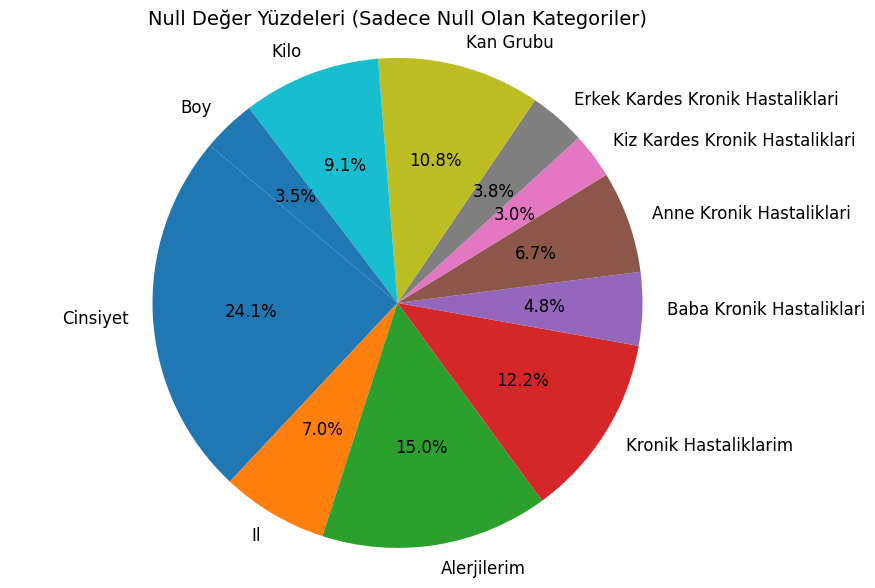

In [65]:
# Null değerlerin yüzdesini hesapla
null_percentages = veri.isnull().mean() * 100

# Sadece null değer içeren kategorileri filtrele
null_percentages = null_percentages[null_percentages > 0]

# Pasta grafiği oluştur
plt.figure(figsize=(10, 7))
plt.pie(null_percentages, labels=null_percentages.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Null Değer Yüzdeleri (Sadece Null Olan Kategoriler)', fontsize=14)
plt.axis('equal')  # Eşit eksen oranı için
plt.show()


İşte bu pasta dilimi grafiği başlangıçta veri setimizde hangi kategoride yüzde kaç null değer olduğunu gösteriyor. Adım adım kategorilerdeki null değerleri gereken yerde mantıksal olarak analizlere dayanarak, bazı yerlerde ise en çok tekrar eden ya da ortalama değer gibi referanslarla doldurdum ve tutarsızlıkları da ortadan kaldırarak veri setimizi modellemeye hazır hale getirdim.

---

## Kaynaklar

- [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [Seaborn Documentation](https://seaborn.pydata.org/)
- J. VanderPlas, *Python Data Science Handbook*, O'Reilly Media, 2016
- A. Müller & S. Guido, *Introduction to Machine Learning with Python*, O'Reilly Media, 2016
- https://www.kaggle.com/
- https://medium.com/global-ai-hub


---
